In [56]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sms
import datetime

import statsmodels.api as sm
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras_tuner import RandomSearch
from keras.optimizers import Adam


In [57]:
df = pd.read_excel("data.xlsx")

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4417 entries, 0 to 4416
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date/Time      4417 non-null   datetime64[ns]
 1   Constraint DA  4417 non-null   float64       
 2   Constraint RT  4417 non-null   float64       
 3   Wind           4412 non-null   float64       
 4   Solar          4416 non-null   float64       
 5   AEP Load       4417 non-null   int64         
 6   ATSI Load      4417 non-null   int64         
 7   COMED Load     4417 non-null   int64         
 8   DOM Load       4417 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 310.7 KB


In [59]:
df.isna().sum()

Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             5
Solar            1
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [60]:
# replace any missing values with the next value. 
# I choose foward fill (ffill) instead of the standard replacement (mean) as it seemed more appropiate for timeseries
df = df.fillna(method='ffill')

In [61]:
df.isna().sum()


Date/Time        0
Constraint DA    0
Constraint RT    0
Wind             0
Solar            0
AEP Load         0
ATSI Load        0
COMED Load       0
DOM Load         0
dtype: int64

In [62]:
# Feature Engineering
df['hour'] = df['Date/Time'].dt.hour
df['day_of_week'] = df['Date/Time'].dt.dayofweek
df["month"] = df["Date/Time"].dt.month_name()

In [63]:
df.head()

,Date/Time,Constraint DA,Constraint RT,Wind,Solar,AEP Load,ATSI Load,COMED Load,DOM Load,hour,day_of_week,month
0,2021-07-01 01:00:00,0.0,0.0,753.281,0.0,14236,7455,11651,14123,1,3,July
1,2021-07-01 02:00:00,0.0,0.0,738.755,0.0,13636,7091,10871,13345,2,3,July
2,2021-07-01 03:00:00,0.0,0.0,724.276,0.0,13171,6850,10313,12765,3,3,July
3,2021-07-01 04:00:00,0.0,0.0,752.041,0.0,12962,6714,9925,12393,4,3,July
4,2021-07-01 05:00:00,0.0,0.0,759.611,0.0,13060,6730,9731,12293,5,3,July


In [64]:
df.describe()

,Constraint DA,Constraint RT,Wind,Solar,AEP Load,ATSI Load,COMED Load,DOM Load,hour,day_of_week
count,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000,4417.000000
mean,-38.573711,-49.394247,2757.547343,753.184830,14565.183835,7671.254471,11293.011320,12668.480190,11.497849,3.006566
std,115.701292,216.464412,2008.500334,963.148803,2355.529217,1380.445211,2476.481713,2492.093186,6.923662,1.991195
min,-1737.120000,-1920.610000,119.755000,0.000000,9200.000000,5201.000000,7346.000000,8425.000000,0.000000,0.000000
25%,0.000000,0.000000,1123.795000,0.000000,12930.000000,6668.000000,9492.000000,10914.000000,5.000000,1.000000
50%,0.000000,0.000000,2220.221000,22.752000,14203.000000,7443.000000,10762.000000,12135.000000,11.000000,3.000000
75%,0.000000,0.000000,4054.887000,1558.308000,15947.000000,8345.000000,12353.000000,14010.000000,17.000000,5.000000
max,0.000000,0.000000,9110.341000,3138.696000,22122.000000,12796.000000,20388.000000,20213.000000,23.000000,6.000000


# Data Exploration

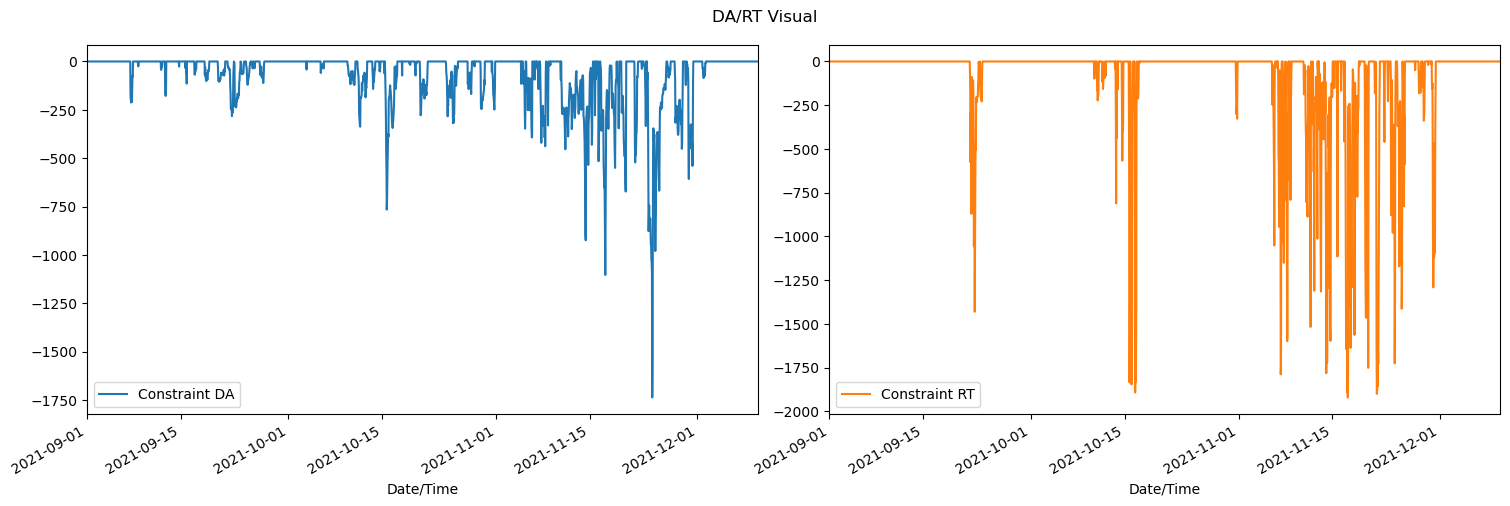

In [65]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

load_cols = ['Constraint DA', 'Constraint RT']

df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(15, 5), title="DA/RT Visual")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


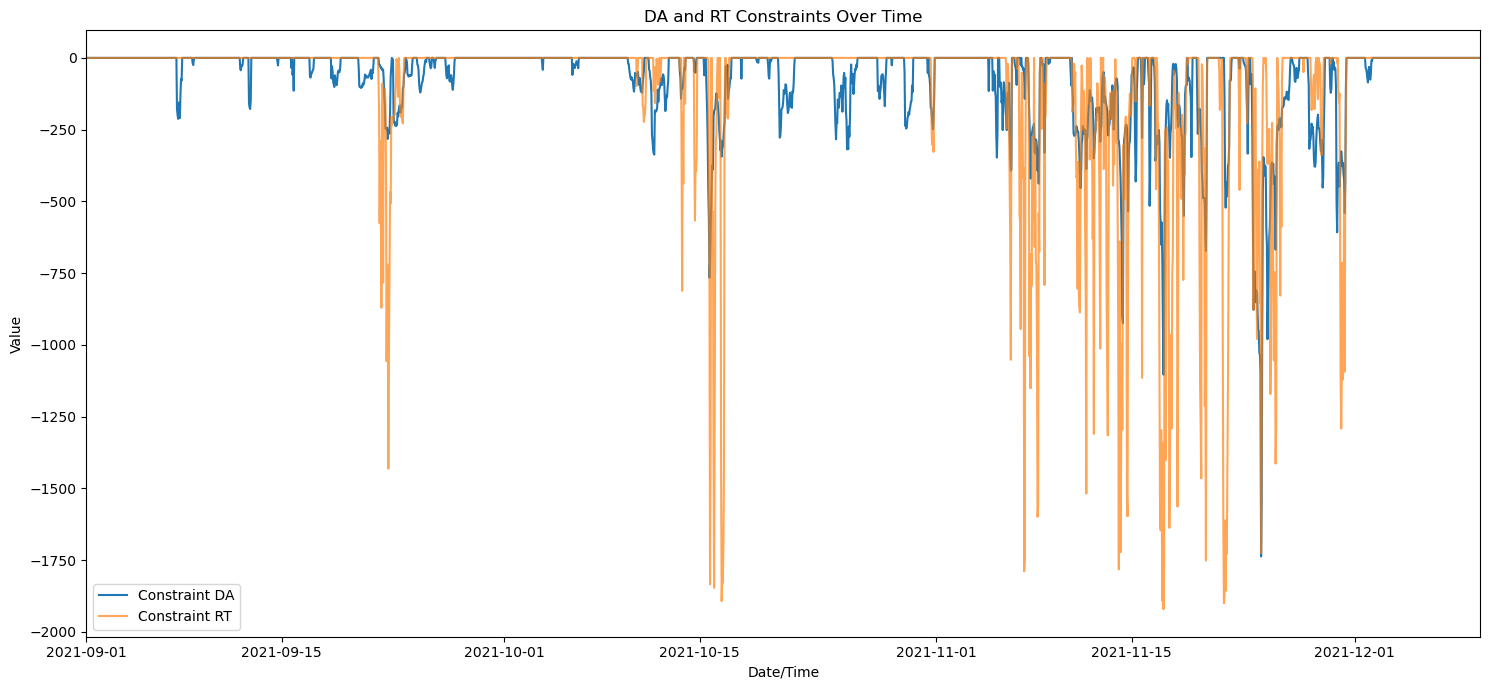

In [66]:
plt.figure(figsize=(15, 7))
plt.plot(df['Date/Time'], df['Constraint DA'], label='Constraint DA')
plt.plot(df['Date/Time'], df['Constraint RT'], label='Constraint RT', alpha=0.7)
plt.title('DA and RT Constraints Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.legend(loc='best')
start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])
plt.tight_layout()
plt.show()


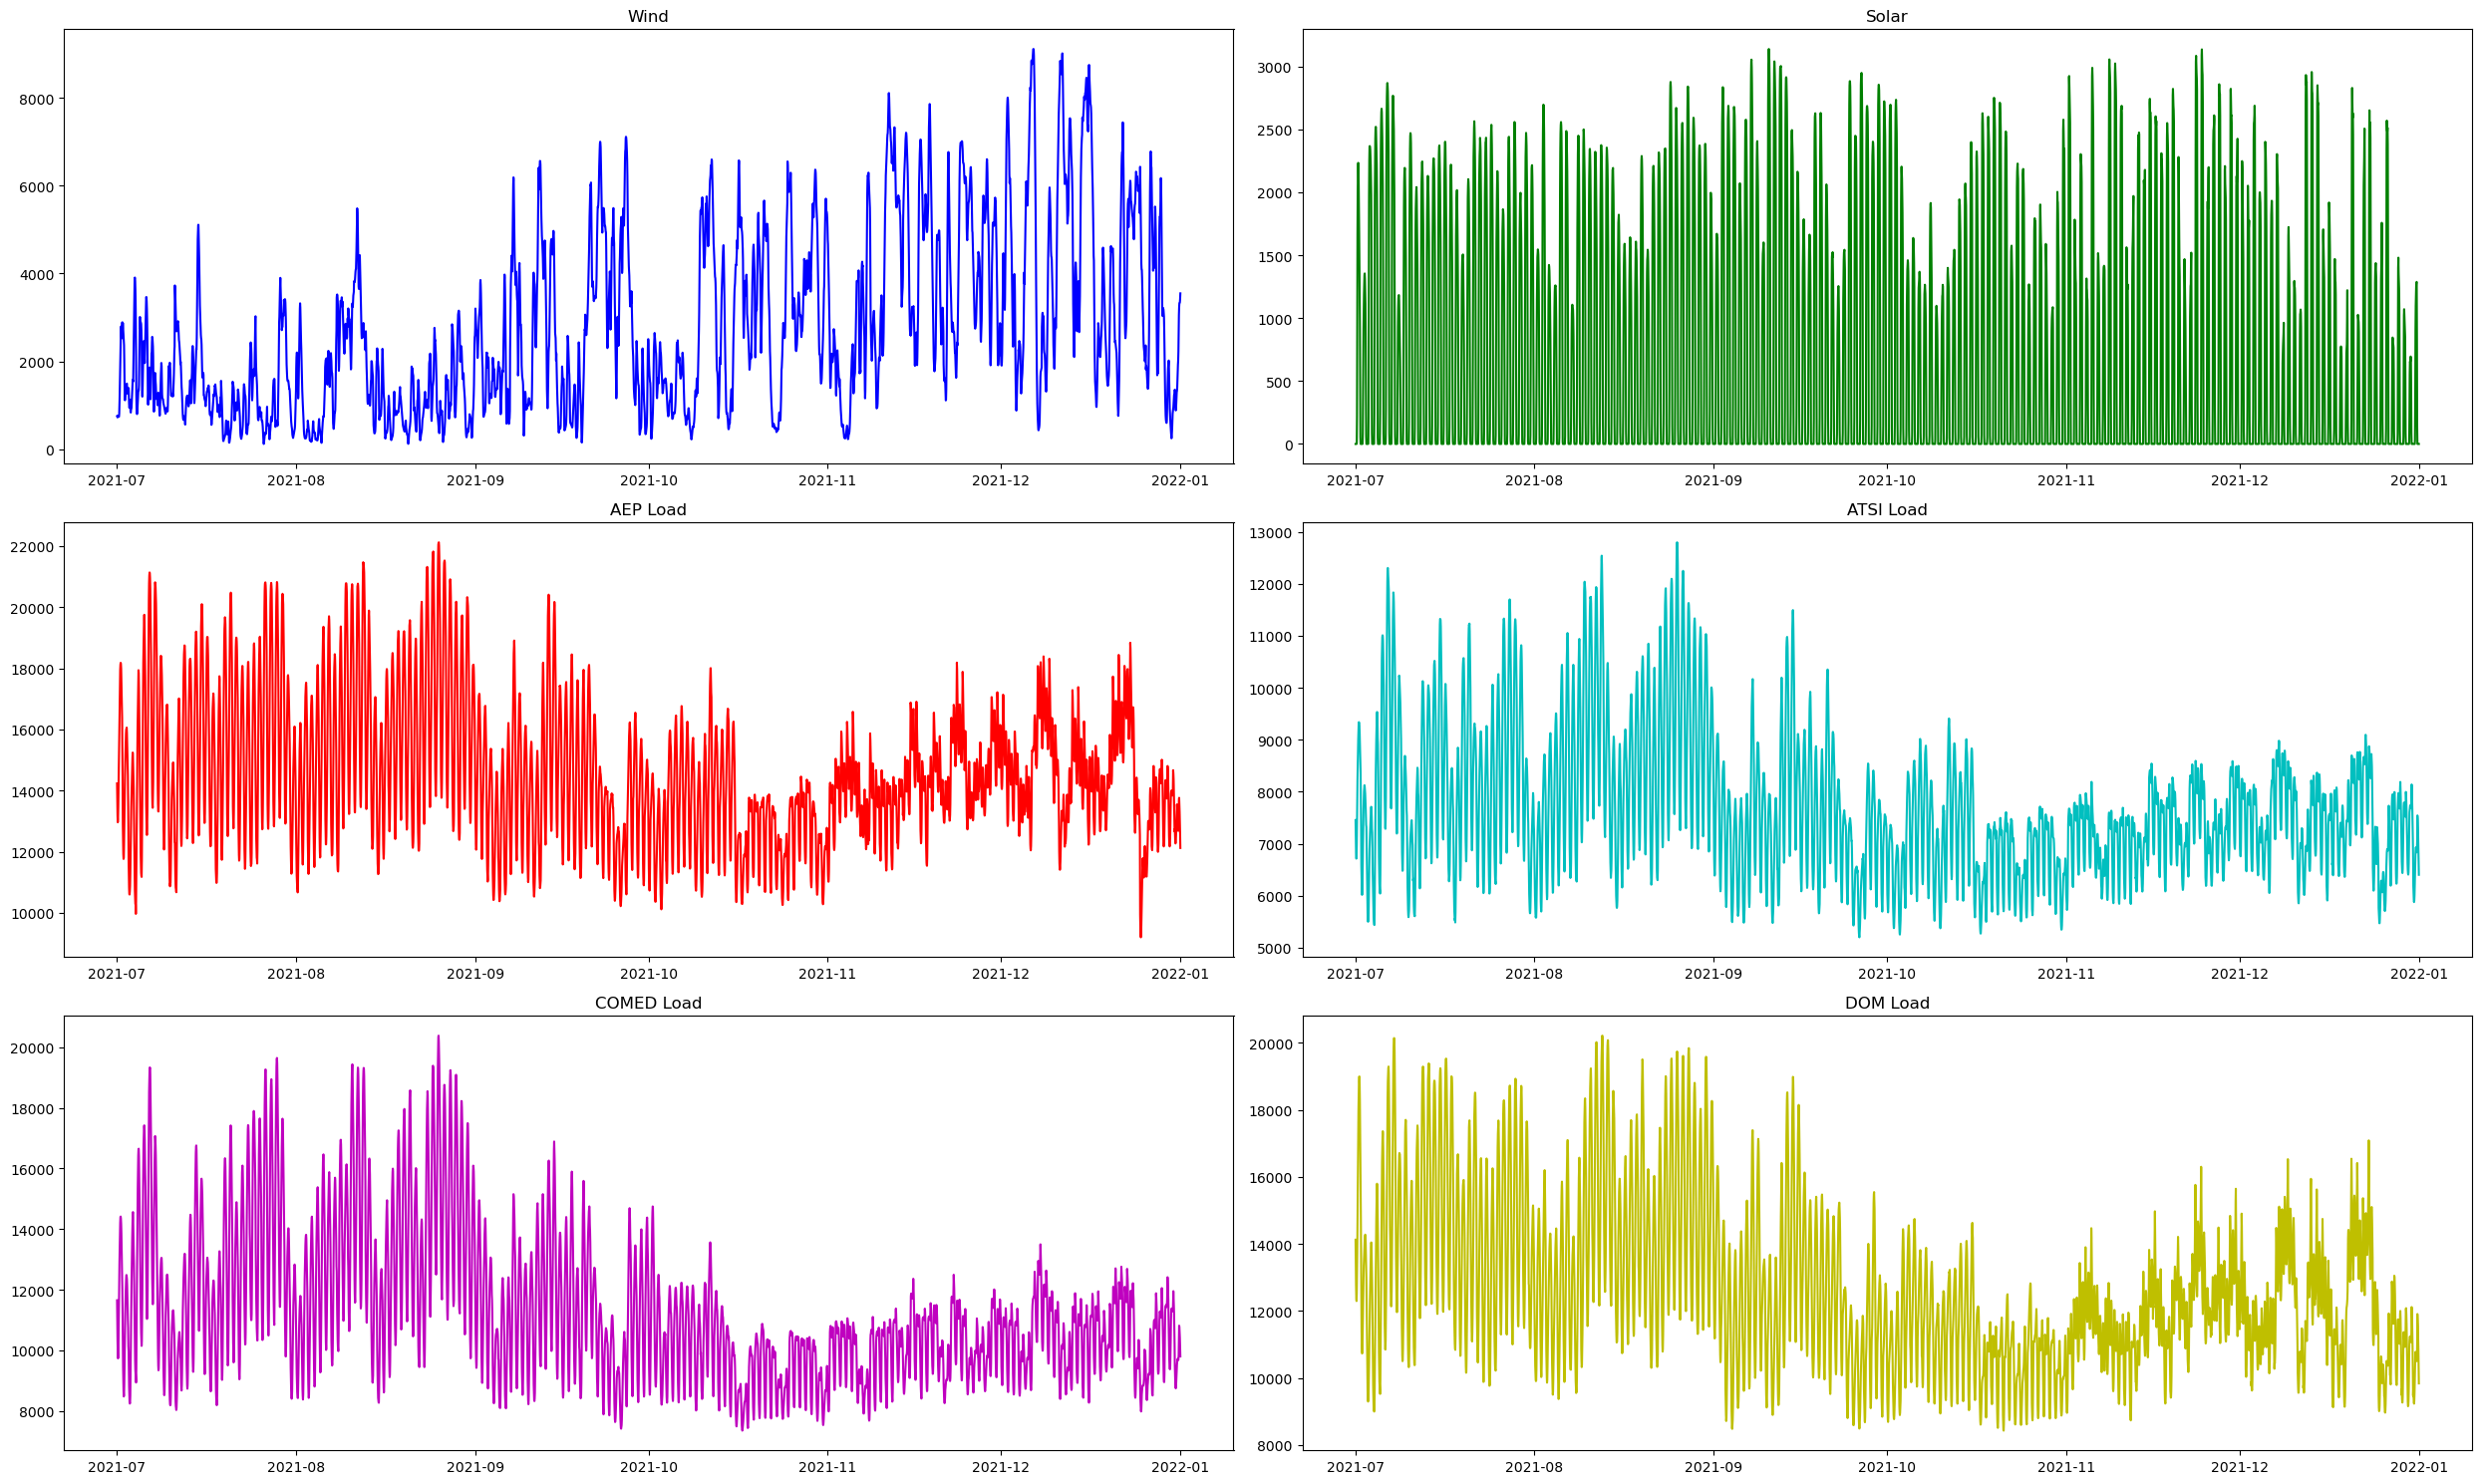

In [67]:
load_cols = ['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']
# df.set_index('Date/Time')[load_cols].plot(subplots=True, layout=(-1, 2), figsize=(25, 15))
# plt.tight_layout()
# plt.show()

colors = ['b', 'g', 'r', 'c', 'm', 'y']

fig, axs = plt.subplots(len(load_cols)//2, 2, figsize=(25, 15))  
axs = axs.ravel() 

start_date = datetime.datetime(2021, 7, 1)
end_date = datetime.datetime(2021, 12, 10)

for i, col in enumerate(load_cols):
    axs[i].plot(df['Date/Time'], df[col], color=colors[i % len(colors)])  
    axs[i].set_title(col)  
    #axs[i].set_xlim([start_date, end_date]) 

plt.tight_layout()
plt.show()


## Other Plots

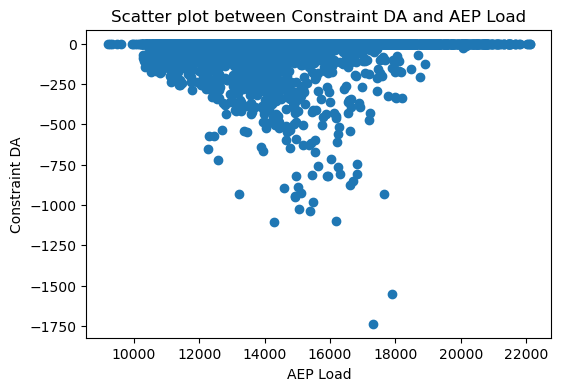

In [68]:
# Create a scatter plot for 'Constraint DA' and 'AEP Load'
plt.figure(figsize=(6, 4))
plt.scatter(df['AEP Load'], df['Constraint DA'])
plt.xlabel('AEP Load')
plt.ylabel('Constraint DA')
plt.title('Scatter plot between Constraint DA and AEP Load')
plt.show()


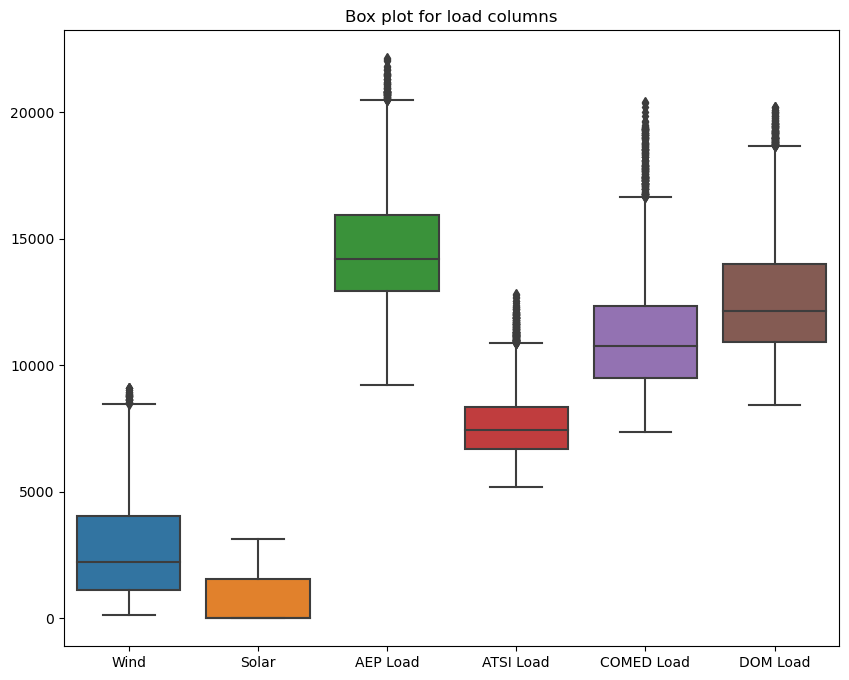

In [69]:
# Boxplot for load columns
plt.figure(figsize=(10, 8))
sms.boxplot(data=df[load_cols])
plt.title('Box plot for load columns')
plt.show()


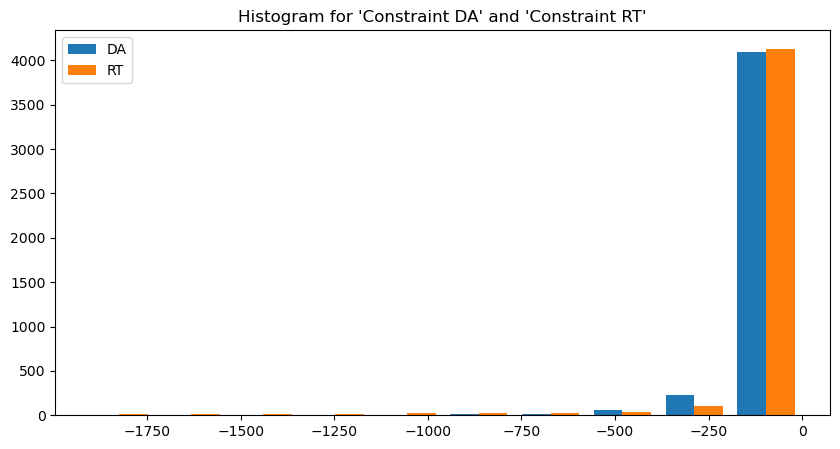

In [70]:
# Histogram for 'Constraint DA' and 'Constraint RT'
plt.figure(figsize=(10, 5))
plt.hist(df[['Constraint DA', 'Constraint RT']])
plt.legend(["DA", "RT"])
plt.title("Histogram for 'Constraint DA' and 'Constraint RT'")
plt.show()


C:\Users\William Hazen\AppData\Local\Temp\ipykernel_19824\517219142.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


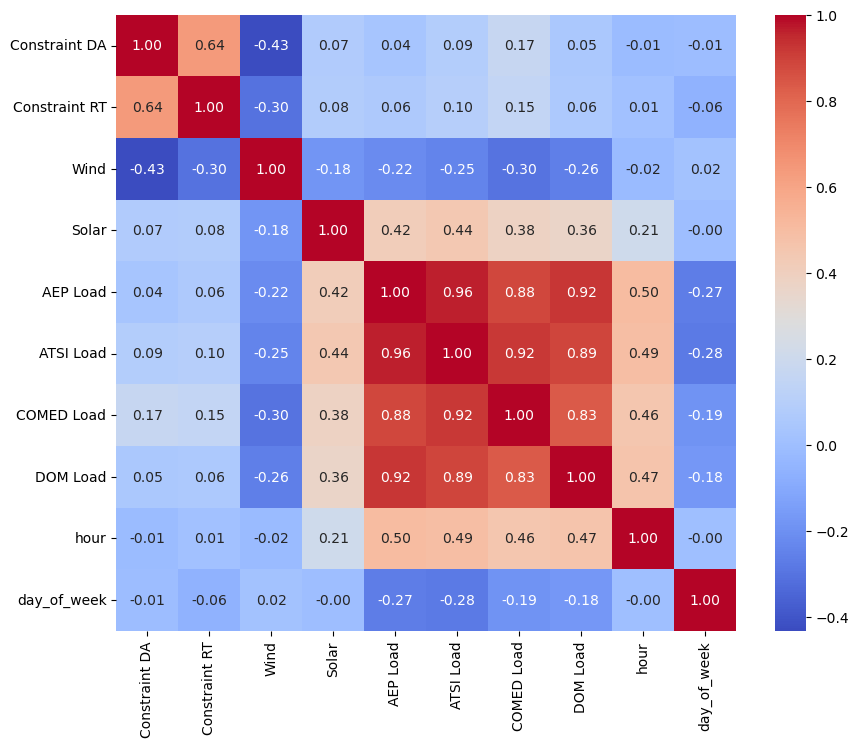

In [71]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sms.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()


## Testing for Stationarity

In [72]:
from statsmodels.tsa.stattools import adfuller

In [73]:
# Ho: It is non stationary
# H1: It is stationary
def adfuller_test(sales):
    result = adfuller(sales)
    labels = ['ADF Test Statistic', 'p-value',
              '#Lags Used', 'Number of Observations Used']
    for value, label in zip(result, labels):
        print(label+' : '+str(value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary")


In [74]:
adfuller_test(df['Constraint DA'])


ADF Test Statistic : -6.610039001653793
p-value : 6.411176517556501e-09
#Lags Used : 31
Number of Observations Used : 4385
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [75]:
adfuller_test(df['Constraint RT'])

ADF Test Statistic : -7.707404867001107
p-value : 1.2906000226292755e-11
#Lags Used : 29
Number of Observations Used : 4387
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


- It appears that for both constraints (DA/RT) are stationary timeseries. This indicated that one whose properties do not depend on the time at which the series is observe.

- However, when looking that the plots. DA and RT only show non-zero values between September to December. Not sure the reason for this but it could be related to seasonal relationships - indicating non startionary timeseries

## Differencing 

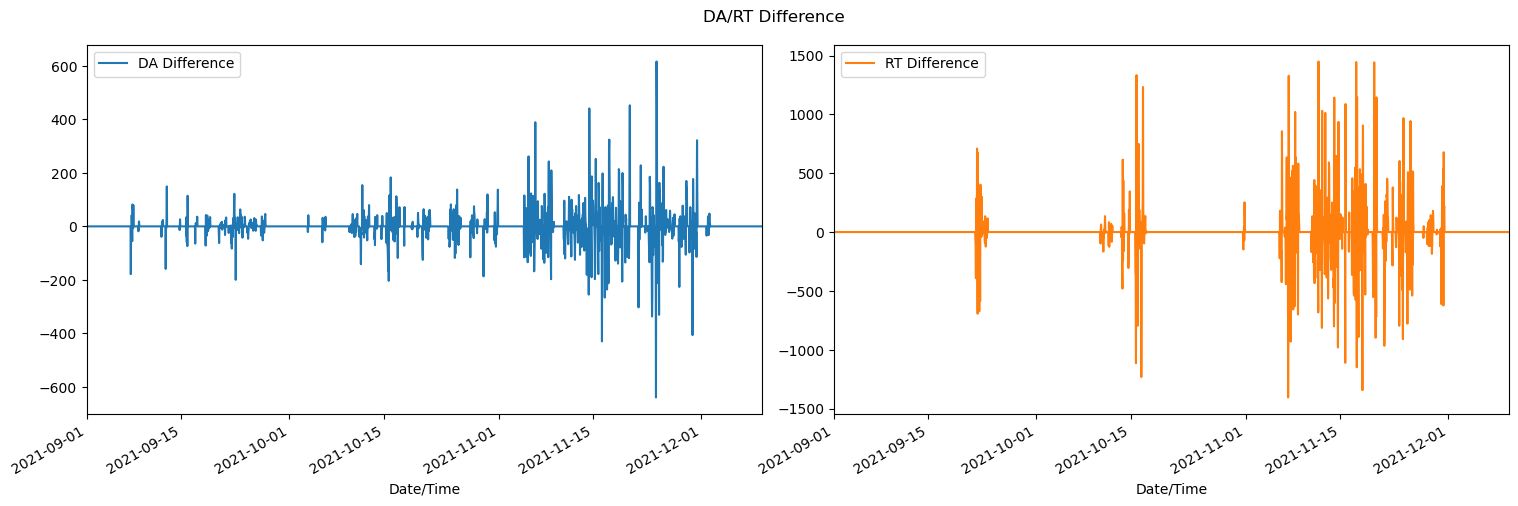

In [76]:
df['DA Difference'] = df['Constraint DA'] - df['Constraint DA'].shift(1)
df['RT Difference'] = df['Constraint RT'] - df['Constraint RT'].shift(1)

load_cols = ['DA Difference', 'RT Difference']

df.set_index('Date/Time')[load_cols].plot(subplots=True,
                                          layout=(-1, 2), figsize=(15, 5), title="DA/RT Difference")
plt.tight_layout()

start_date = datetime.datetime(2021, 9, 1)
end_date = datetime.datetime(2021, 12, 10)
plt.xlim([start_date, end_date])

plt.show()


# Multivariate LSTM

In [92]:

# Define the input features and the output features
input_features = df[['Wind', 'Solar', 'AEP Load',
                     'ATSI Load', 'COMED Load', 'DOM Load']]
output_features = df[['Constraint DA', 'Constraint RT']]

# Define two different scalers
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers to the relevant data
scaled_input = input_scaler.fit_transform(input_features)
scaled_output = output_scaler.fit_transform(output_features)

# Combine the scaled input and output into one array
scaled_features = np.concatenate((scaled_output, scaled_input), axis=1)

# Split into train and test sets
train_size = int(len(scaled_features) * 0.7)
test_size = len(scaled_features) - train_size
train, test = scaled_features[0:train_size,
                              :], scaled_features[train_size:len(scaled_features), :]

# Convert an array of values into a dataset matrix


def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 2:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :2])
    return np.array(dataX), np.array(dataY)


# Reshape into X=t and Y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))


In [109]:
# Create a new instance of the LSTM model to make sure the model is resetting everytime. The loss had some issues before.
def create_model():
    model = Sequential()
    model.reset_states()
    model.add(LSTM(6, return_sequences=True,input_shape=(X_train.shape[1], 6)))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dense(units=50))
    model.add(Dropout(0.2))

    model.add(LSTM(units=50))
    model.add(Dense(units=2))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 2:]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :2])
    return np.array(dataX), np.array(dataY)


In [120]:
# Define the input features and the output features
input_features = df[['Wind', 'Solar', 'AEP Load',
                     'ATSI Load', 'COMED Load', 'DOM Load']]
output_features = df[['Constraint DA', 'Constraint RT']]

# Define two different scalers
input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit the scalers to the relevant data
scaled_input = input_scaler.fit_transform(input_features)
scaled_output = output_scaler.fit_transform(output_features)

# Combine the scaled input and output into one array
scaled_features = np.concatenate((scaled_output, scaled_input), axis=1)

# Split into train and test sets
train_size = int(len(scaled_features) * 0.7)
test_size = len(scaled_features) - train_size
train, test = scaled_features[0:train_size,:], scaled_features[train_size:len(scaled_features), :]

# Reshape into X=t and Y=t+1
look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))


model = create_model()
LSTM_Model = model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)


Epoch 1/100
194/194 [==============================] - 9s 7ms/step - loss: 0.1281
Epoch 2/100
194/194 [==============================] - 1s 8ms/step - loss: 0.0125
Epoch 3/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 4/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0094
Epoch 5/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0088
Epoch 6/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0082
Epoch 7/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0077
Epoch 8/100
194/194 [==============================] - 1s 6ms/step - loss: 0.0073
Epoch 9/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0070
Epoch 10/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0068
Epoch 11/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 12/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0067
Epoch 13/100


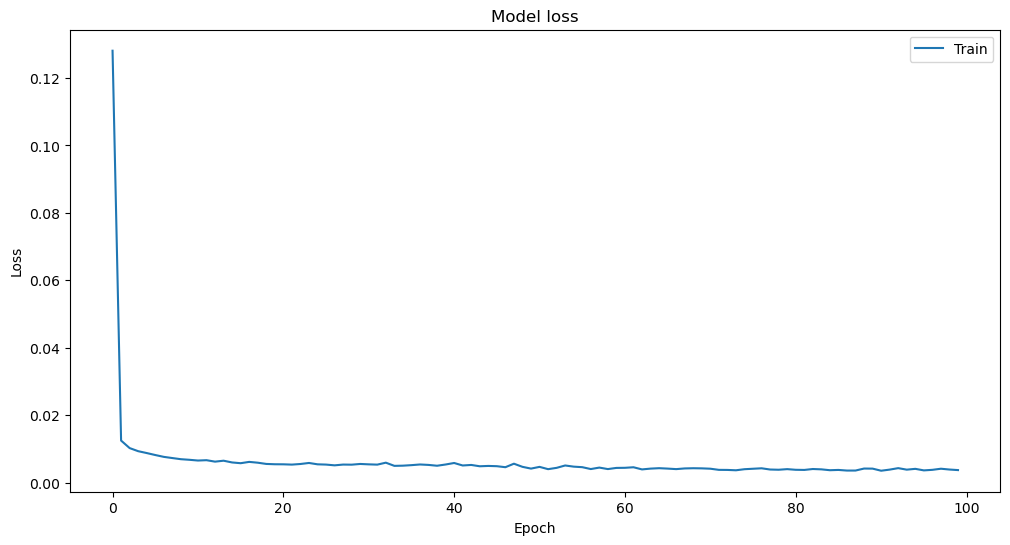

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(LSTM_Model.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

In [112]:
# Make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# Invert predictions and targets to unscaled
trainPredict = output_scaler.inverse_transform(trainPredict)
y_train = output_scaler.inverse_transform(y_train)
testPredict = output_scaler.inverse_transform(testPredict)
y_test = output_scaler.inverse_transform(y_test)

# Calculate root mean squared error
print("DA")
trainScore = np.sqrt(mean_squared_error(y_train[:, 0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:, 0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

print("RT")
trainScore = np.sqrt(mean_squared_error(y_train[:, 1], trainPredict[:, 1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:, 1], testPredict[:, 1]))
print('Test Score: %.2f RMSE' % (testScore))


42/42 [==============================] - 0s 3ms/step
DA
Train Score: 38.22 RMSE
Test Score: 175.92 RMSE
RT
Train Score: 74.01 RMSE
Test Score: 419.69 RMSE


## Constraint DA

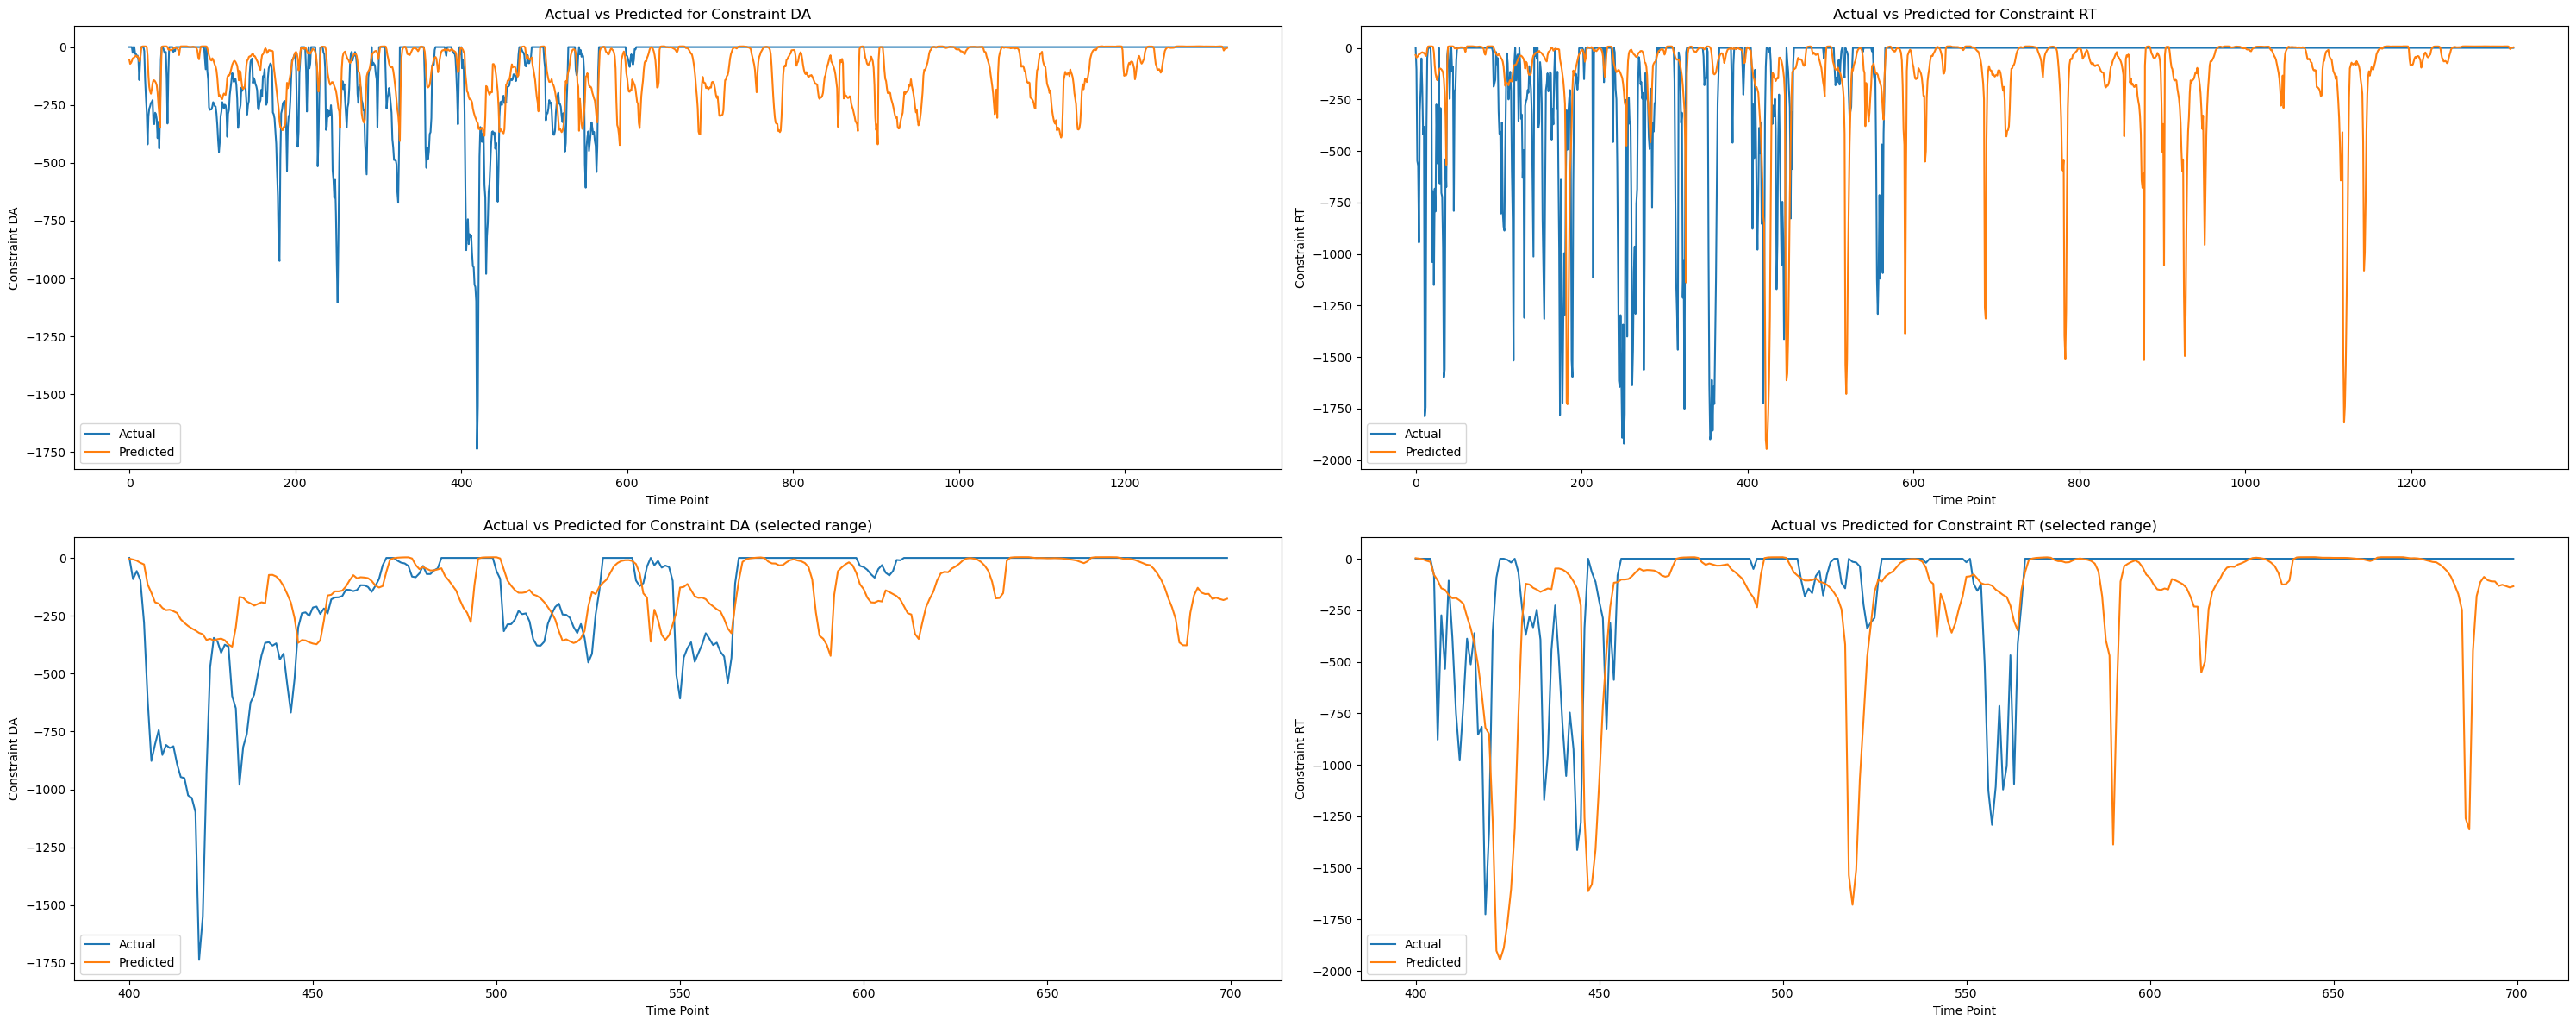

In [133]:
time_point = range(len(y_test))

start_index = 400  # Adjust this to change the starting index of the plot
end_index = 700  # Adjust this to change the ending index of the plot


fig, axs = plt.subplots(2, 2, figsize=(30, 12))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_test[:, 0], label='Actual')
axs[0, 0].plot(time_point, testPredict[:, 0], label='Predicted')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_test[:, 1], label='Actual')
axs[0, 1].plot(time_point, testPredict[:, 1], label='Predicted')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA (selected range)
axs[1, 0].plot(time_point[start_index:end_index], y_test[start_index:end_index, 0], label='Actual')
axs[1, 0].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 0], label='Predicted')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA (selected range)')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT (selected range)
axs[1, 1].plot(time_point[start_index:end_index], y_test[start_index:end_index, 1], label='Actual')
axs[1, 1].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 1], label='Predicted')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT (selected range)')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Hyperparamter optimzation (LSTM)

In [122]:
# Preprocessing outside of the function
input_features = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']]
output_features = df[['Constraint DA', 'Constraint RT']]

input_scaler = MinMaxScaler(feature_range=(-1, 1))
output_scaler = MinMaxScaler(feature_range=(-1, 1))

scaled_input = input_scaler.fit_transform(input_features)
scaled_output = output_scaler.fit_transform(output_features)

scaled_features = np.concatenate((scaled_output, scaled_input), axis=1)
train_size = int(len(scaled_features) * 0.7)
test_size = len(scaled_features) - train_size
train, test = scaled_features[0:train_size,:], scaled_features[train_size:len(scaled_features), :]

look_back = 1
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], look_back, X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, X_test.shape[2]))


def tuned_model(HP_Tuner):
    model = Sequential()
    model.add(LSTM(HP_Tuner.Int('input_units', min_value=4, max_value=20, step=2), return_sequences=True, input_shape=(X_train.shape[1], 6)))
    model.add(Dense(units=HP_Tuner.Int('dense_units_1', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_1', min_value=30, max_value=70, step=10), return_sequences=True))
    model.add(Dense(units=HP_Tuner.Int('dense_units_2', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_2', min_value=30, max_value=70, step=10), return_sequences=True))
    model.add(Dense(units=HP_Tuner.Int('dense_units_3', min_value=30, max_value=70, step=10)))
    model.add(Dropout(HP_Tuner.Float('dropout_3', min_value=0.1, max_value=0.5, step=0.1)))

    model.add(LSTM(units=HP_Tuner.Int('lstm_units_3', min_value=30, max_value=70, step=10)))
    model.add(Dense(units=2))
    
    model.compile(loss='mean_squared_error', optimizer=Adam(HP_Tuner.Choice('learning_rate',values=[1e-2, 1e-3, 1e-4])))
    
    return model


tuner = RandomSearch(
    tuned_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))


Trial 5 Complete [00h 00m 47s]
val_loss: 0.0872279480099678

Best val_loss So Far: 0.08261521657307942
Total elapsed time: 00h 03m 53s
INFO:tensorflow:Oracle triggered exit


In [123]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]
bm = best_model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=1)

Epoch 1/100
194/194 [==============================] - 9s 8ms/step - loss: 0.0325
Epoch 2/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0267
Epoch 3/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0231
Epoch 4/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 5/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0139
Epoch 6/100
194/194 [==============================] - 1s 6ms/step - loss: 0.0117
Epoch 7/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0108
Epoch 8/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0107
Epoch 9/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 10/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0105
Epoch 11/100
194/194 [==============================] - 2s 8ms/step - loss: 0.0103
Epoch 12/100
194/194 [==============================] - 1s 7ms/step - loss: 0.0104
Epoch 13/100


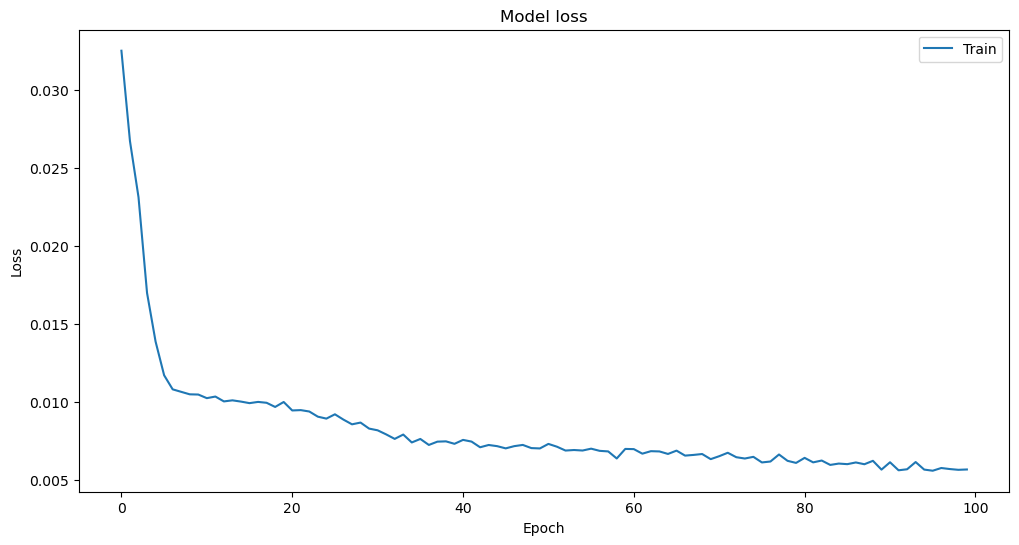

In [124]:
plt.figure(figsize=(12, 6))
plt.plot(bm.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()


In [125]:
# Make predictions with the best model
bm_trainPredict = best_model.predict(X_train)
bm_testPredict = best_model.predict(X_test)

# Invert predictions and targets to unscaled
bm_trainPredict = output_scaler.inverse_transform(bm_trainPredict)
y_train = output_scaler.inverse_transform(y_train)
bm_testPredict = output_scaler.inverse_transform(bm_testPredict)
y_test = output_scaler.inverse_transform(y_test)

# Calculate root mean squared error
print("DA for Best Model")
trainScore = np.sqrt(mean_squared_error(y_train[:, 0], bm_trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:, 0], bm_testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

print("RT for Best model")
trainScore = np.sqrt(mean_squared_error(y_train[:, 1], bm_trainPredict[:, 1]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(y_test[:, 1], bm_testPredict[:, 1]))
print('Test Score: %.2f RMSE' % (testScore))


42/42 [==============================] - 0s 3ms/step
DA for Best Model
Train Score: 46.75 RMSE
Test Score: 182.09 RMSE
RT for Best model
Train Score: 83.35 RMSE
Test Score: 492.65 RMSE


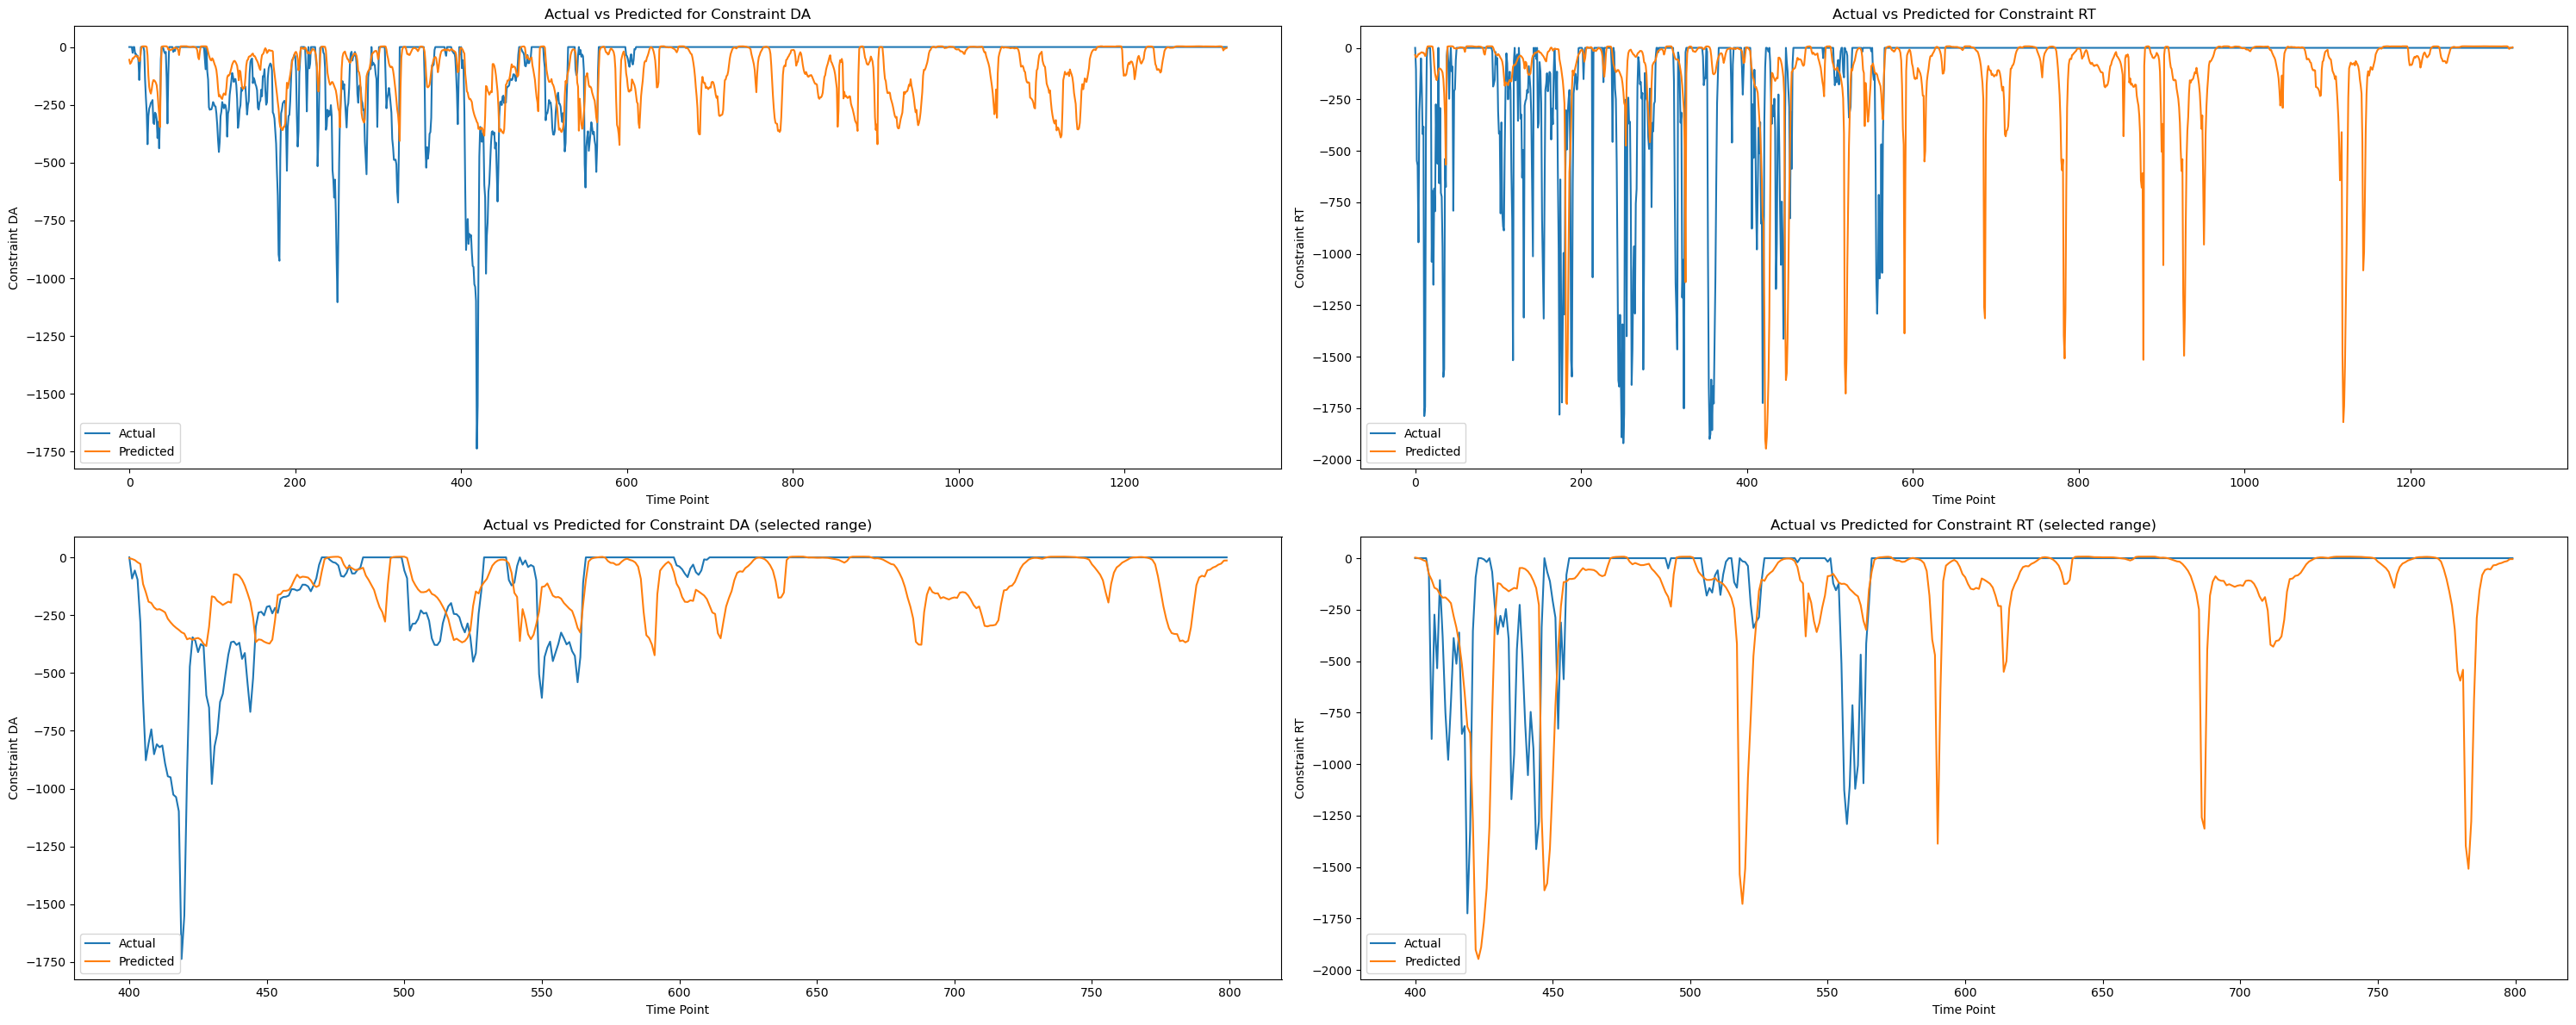

In [130]:
time_point = range(len(y_test))

start_index = 400  # Adjust this to change the starting index of the plot
end_index = 800  # Adjust this to change the ending index of the plot


fig, axs = plt.subplots(2, 2, figsize=(30, 12))

# Plot 1: Actual vs Predicted for Constraint DA (full range)
axs[0, 0].plot(time_point, y_test[:, 0], label='Actual')
axs[0, 0].plot(time_point, testPredict[:, 0], label='Predicted')
axs[0, 0].set_title('Actual vs Predicted for Constraint DA')
axs[0, 0].set_xlabel('Time Point')
axs[0, 0].set_ylabel('Constraint DA')
axs[0, 0].legend()

# Plot 2: Actual vs Predicted for Constraint RT (full range)
axs[0, 1].plot(time_point, y_test[:, 1], label='Actual')
axs[0, 1].plot(time_point, testPredict[:, 1], label='Predicted')
axs[0, 1].set_title('Actual vs Predicted for Constraint RT')
axs[0, 1].set_xlabel('Time Point')
axs[0, 1].set_ylabel('Constraint RT')
axs[0, 1].legend()

# Plot 3: Actual vs Predicted for Constraint DA (selected range)
axs[1, 0].plot(time_point[start_index:end_index], y_test[start_index:end_index, 0], label='Actual')
axs[1, 0].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 0], label='Predicted')
axs[1, 0].set_title('Actual vs Predicted for Constraint DA (selected range)')
axs[1, 0].set_xlabel('Time Point')
axs[1, 0].set_ylabel('Constraint DA')
axs[1, 0].legend()

# Plot 4: Actual vs Predicted for Constraint RT (selected range)
axs[1, 1].plot(time_point[start_index:end_index], y_test[start_index:end_index, 1], label='Actual')
axs[1, 1].plot(time_point[start_index:end_index], testPredict[start_index:end_index, 1], label='Predicted')
axs[1, 1].set_title('Actual vs Predicted for Constraint RT (selected range)')
axs[1, 1].set_xlabel('Time Point')
axs[1, 1].set_ylabel('Constraint RT')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

# Linear Regression

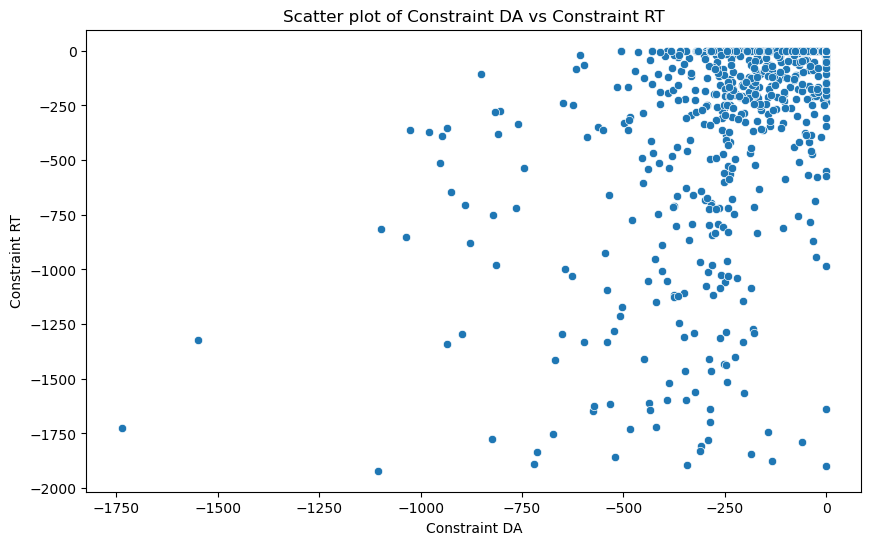

Pearson correlation coefficient: 0.638


In [87]:
plt.figure(figsize=(10, 6))
sms.scatterplot(data=df, x='Constraint DA', y='Constraint RT')
plt.title('Scatter plot of Constraint DA vs Constraint RT')
plt.show()

correlation, _ = pearsonr(df['Constraint DA'], df['Constraint RT'])
print('Pearson correlation coefficient: %.3f' % correlation)


A correlation coefficient of 0.638 suggest a moderate postive linear relationship, but it's not a very strong one. So, as one variable increases, the other tends to increase as well, but not perfectly. However, correlation does not imply causation. Even if two variables have a strong linear relationship, it does not mean that changes in one variable are causing changes in the other. It just means they tend to move together (Relatively).

In [88]:
X = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']]
y_DA = df['Constraint DA']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_DA, test_size=0.2, random_state=42)

# Initialize and fit the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for DA Constraint: {mse}')

# Repeat the process for Constraint RT
y_RT = df['Constraint RT']
X_train, X_test, y_train, y_test = train_test_split(
    X, y_RT, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for RT Constraint: {mse}')


Mean Squared Error for DA Constraint: 8232.471917271228
Mean Squared Error for RT Constraint: 34671.4794248925


In [89]:

# Model Selection
X = df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load',
        'DOM Load']]  # predictors
y_DA = df['Constraint DA']  # target
y_RT = df['Constraint RT']  # target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y_DA, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE:  90.73297039814815


In [90]:
from sklearn.impute import SimpleImputer

# Use a median imputer
imputer = SimpleImputer(strategy='mean')

# Train the imputer (this computes the median for each column)
imputer.fit(X_train)

# Transform the data (this replaces missing values with the medians)
X_train_imputed = imputer.transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Continue with the model training...
model = LinearRegression()
model.fit(X_train_imputed, y_train)

# Evaluate the model
y_pred = model.predict(X_test_imputed)
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))


RMSE:  90.73297039814815


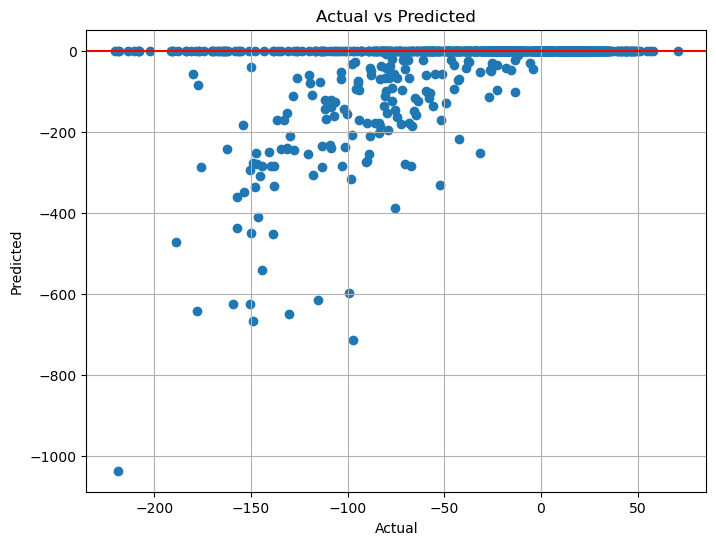

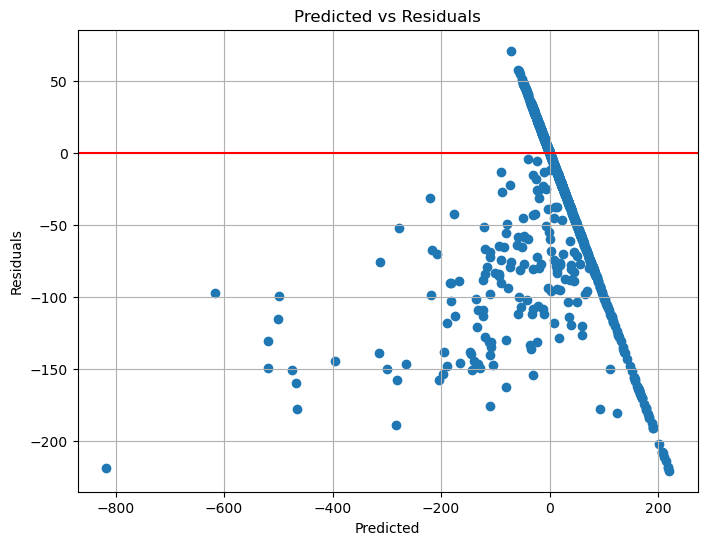

In [91]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.axhline(y=0, color='r', linestyle='-')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Plot residuals
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(residuals, y_pred)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Predicted vs Residuals')
plt.grid(True)
plt.show()


# SARIMAX

In [86]:
# import statsmodels.api as sm

# # Define the model
# model = sm.tsa.statespace.SARIMAX(df['Constraint DA'],
#                                   order=(1, 1, 1),
#                                   seasonal_order=(1, 1, 1, 12),
#                                   exog=df[['Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']])

# # Fit the model
# results = model.fit()

# # Get forecast 10 steps ahead in future
# pred_uc = results.get_forecast(steps=10, exog=df[[
#                                'Wind', 'Solar', 'AEP Load', 'ATSI Load', 'COMED Load', 'DOM Load']])

# # Get confidence intervals of forecasts
# pred_ci = pred_uc.conf_int()


# ARIMA

In [81]:
from statsmodels.tsa.arima.model import ARIMA

In [82]:
DA_series = pd.Series(df['Constraint DA'].values, index=df['Date/Time'])

model = ARIMA(DA_series, order=(1, 1, 1))
model_fit = model.fit()

# summary of fit model
model_fit.summary()


c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in divide
  test_statistic = numer_squared_sum /

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4417
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -22199.414
Date:                Sun, 16 Jul 2023   AIC                          44404.827
Time:                        16:42:33   BIC                          44424.006
Sample:                             0   HQIC                         44411.591
                               - 4417                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0030      0.012      0.244      0.807      -0.021       0.027
ma.L1          0.2853      0.012     24.202      0.000       0.262       0.308
sigma2      1361.2672      5.537    245.851      0.000    1350.415    1372.119
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            661950.43
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        62.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: >

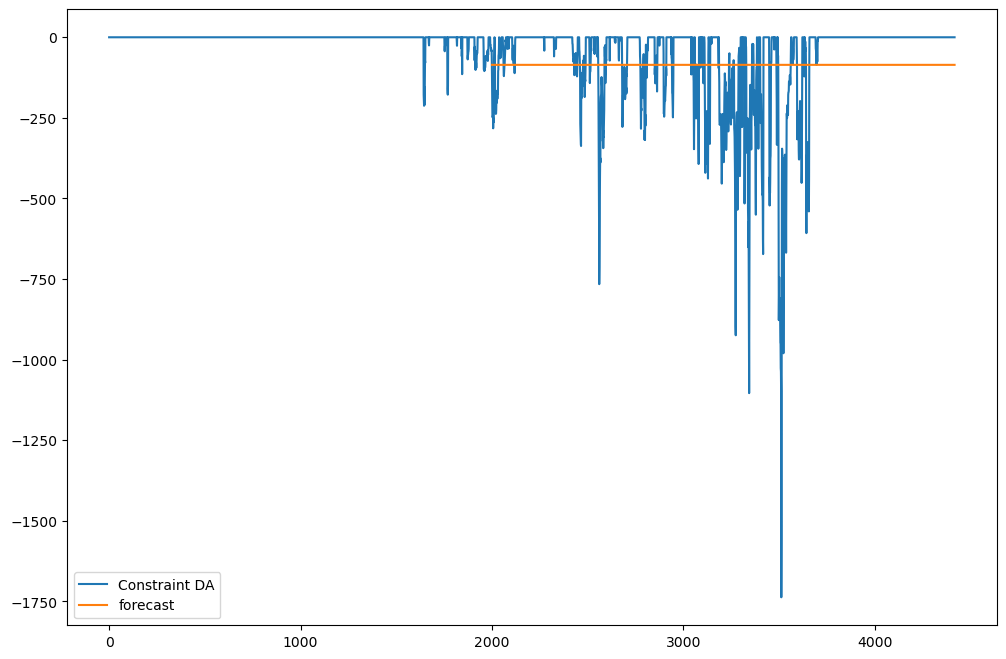

In [83]:
df['forecast']=model_fit.predict(start=2000,end=5000,dynamic=True)
df[['Constraint DA','forecast']].plot(figsize=(12,8))

In [84]:
model=sm.tsa.statespace.SARIMAX(df['Constraint DA'],order=(1, 1, 1),seasonal_order=(1,1,1, 12))
results=model.fit()

<Axes: >

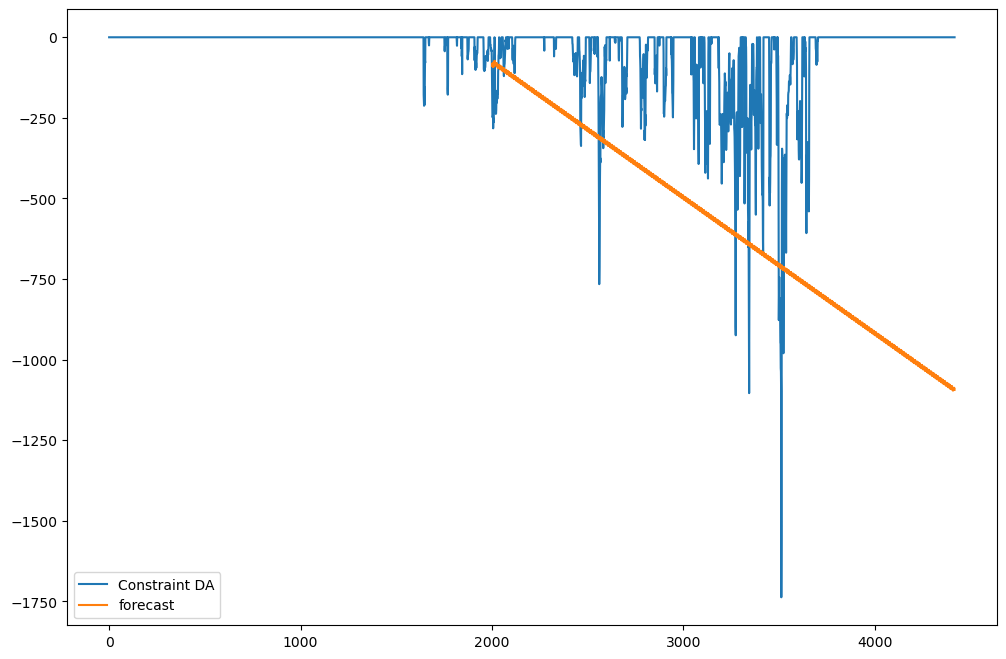

In [85]:
df['forecast']=results.predict(start=2000,end=4500,dynamic=True)
df[['Constraint DA','forecast']].plot(figsize=(12,8))

# AR Model

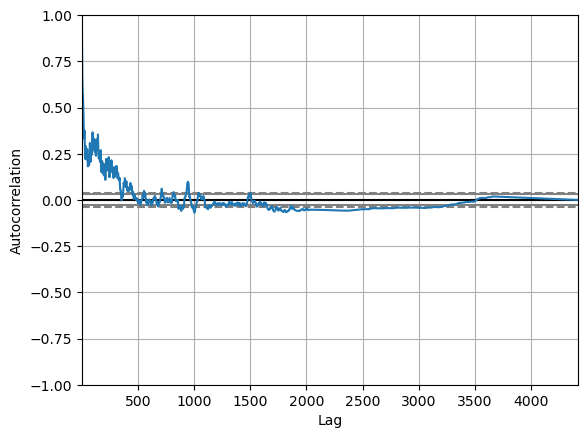

In [77]:
pd.plotting.autocorrelation_plot(df['Constraint DA'])
plt.show()


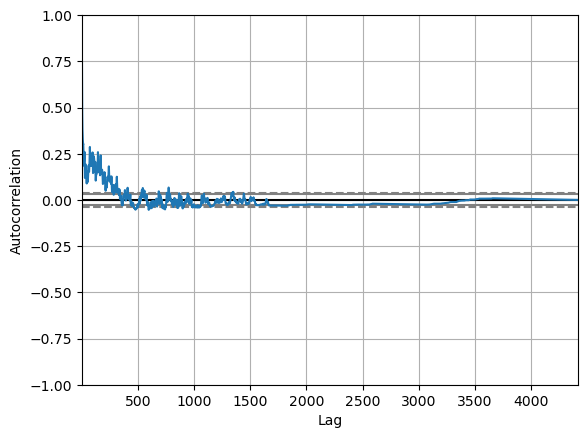

In [78]:
pd.plotting.autocorrelation_plot(df['Constraint RT'])
plt.show()


## Final Thoughts on Autocorrelation and Partial Autocorrelation

https://github.com/krishnaik06/ARIMA-And-Seasonal-ARIMA/blob/master/Untitled.ipynb

- Identification of an AR model is often best done with the PACF.

    - For an AR model, the theoretical PACF “shuts off” past the order of the model. The phrase “shuts off” means that in theory the partial autocorrelations are equal to 0 beyond that point. Put another way, the number of non-zero partial autocorrelations gives the order of the AR model. By the “order of the model” we mean the most extreme lag of x that is used as a predictor.

- Identification of an MA model is often best done with the ACF rather than the PACF.

    - For an MA model, the theoretical PACF does not shut off, but instead tapers toward 0 in some manner. A clearer pattern for an MA model is in the ACF. The ACF will have non-zero autocorrelations only at lags involved in the model.
    
p,d,q p AR model lags d differencing q MA lags

In [79]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


c:\Users\William Hazen\anaconda3\envs\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


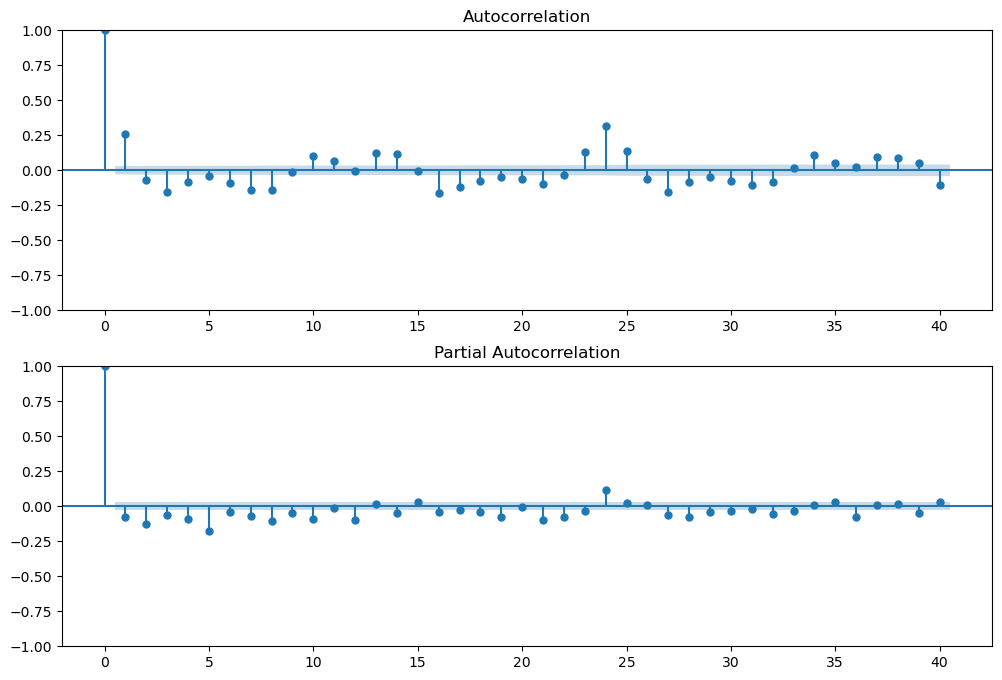

In [80]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['DA Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['RT Difference'].iloc[13:],lags=40,ax=ax2)